In [ ]:
pip install ucimlrepo

In [ ]:
pip install pandas numpy scikit-learn seaborn matplotlib imbalanced-learn

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# 1. Load the Dataset
try:
    # Load with semicolon delimiter, strip whitespace, and handle quotes
    df = pd.read_csv('winequality-red.csv', sep=';', skipinitialspace=True, quoting=csv.QUOTE_ALL)
    df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace
except FileNotFoundError:
    print("Error: 'winequality-red.csv' not found. Please ensure the file is in the same directory or provide the correct path.")
    raise
except pd.errors.ParserError as e:
    print(f"Error: Failed to parse CSV. {e}. Please check the delimiter (should be ';') and file format.")
    print("Trying to load with default delimiter as a fallback...")
    try:
        df = pd.read_csv('winequality-red.csv')  # Fallback to default delimiter
        df.columns = df.columns.str.strip()
    except Exception as e2:
        print(f"Fallback failed: {e2}")
        raise

NameError: name 'csv' is not defined

In [ ]:
# 2. Data Exploration
print("Dataset Shape:", df.shape)
print("Dataset Columns:", df.columns.tolist())
print("\nData Types:")
print(df.dtypes)
print("\nDataset Head:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDataset Description:")
try:
    print(df.describe())
except Exception as e:
    print(f"Error in describe: {e}")

Dataset Shape: (1599, 12)
Dataset Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Data Types:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Dataset Head:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28  

In [ ]:
# Check for 'quality' column
quality_col = None
if 'quality' in df.columns:
    quality_col = 'quality'
else:
    print("\nError: 'quality' column not found. Available columns:", df.columns.tolist())
    # Attempt to find a similar column
    possible_quality_cols = [col for col in df.columns if 'quality' in col.lower()]
    if possible_quality_cols:
        print(f"Possible quality column(s): {possible_quality_cols}")
        quality_col = possible_quality_cols[0]
        print(f"Using '{quality_col}' as the quality column.")
    else:
        raise KeyError("No column resembling 'quality' found in the dataset.")

In [ ]:
# Verify expected columns
expected_columns = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
    'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality'
]
if set(df.columns) != set(expected_columns):
    print("\nWarning: Dataset columns do not match expected UCI wine quality dataset columns.")
    print("Expected columns:", expected_columns)
    print("Actual columns:", df.columns.tolist())
    if len(df.columns) == 1:
        print("Error: Likely incorrect delimiter. DataFrame has only one column, suggesting parsing failure.")
        raise ValueError("CSV parsing failed. Please verify the delimiter in 'winequality-red.csv'.")

In [ ]:
# Check for 'quality' column
quality_col = None
if 'quality' in df.columns:
    quality_col = 'quality'
else:
    print("\nError: 'quality' column not found. Available columns:", df.columns.tolist())
    possible_quality_cols = [col for col in df.columns if 'quality' in col.lower()]
    if possible_quality_cols:
        print(f"Possible quality column(s): {possible_quality_cols}")
        quality_col = possible_quality_cols[0]
        print(f"Using '{quality_col}' as the quality column.")
    else:
        raise KeyError("No column resembling 'quality' found in the dataset.")

In [ ]:
# Convert quality column to numeric
try:
    df[quality_col] = pd.to_numeric(df[quality_col], errors='coerce')
    if df[quality_col].isnull().sum() > 0:
        print(f"\nWarning: {df[quality_col].isnull().sum()} non-numeric values in '{quality_col}' converted to NaN.")
        df[quality_col].fillna(df[quality_col].median(), inplace=True)
except Exception as e:
    print(f"Error converting '{quality_col}' to numeric: {e}")
    raise

In [ ]:
# Convert all feature columns to numeric
feature_columns = [col for col in df.columns if col != quality_col]
for col in feature_columns:
    try:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isnull().sum() > 0:
            print(f"\nWarning: {df[col].isnull().sum()} non-numeric values in '{col}' converted to NaN.")
            df[col].fillna(df[col].median(), inplace=True)
    except Exception as e:
        print(f"Error converting '{col}' to numeric: {e}")
        raise

In [ ]:
# Verify data types
print("\nData Types After Conversion:")
print(df.dtypes)
print(f"Data type of '{quality_col}':", df[quality_col].dtype)


Data Types After Conversion:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object
Data type of 'quality': int64


In [ ]:
# 3. Data Preparation for Regression (Predicting Quality Score)
# Check for missing values
print("\nRegression: Missing Values Check")
print(df.isnull().sum())


Regression: Missing Values Check
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [ ]:
# Remove outliers (top 1% of quality scores)
try:
    quality_threshold = df[quality_col].quantile(0.99)
    df_reg = df[df[quality_col] <= quality_threshold]
    print("\nRegression DataFrame Shape After Outlier Removal:", df_reg.shape)
except TypeError as e:
    print(f"Error calculating quantile for '{quality_col}': {e}")
    raise


Regression DataFrame Shape After Outlier Removal: (1599, 12)


In [ ]:
# Prepare features and target
try:
    X_reg = df_reg.drop(quality_col, axis=1)
    y_reg = df_reg[quality_col]
except KeyError as e:
    print(f"Error dropping '{quality_col}': {e}. Available columns:", df_reg.columns.tolist())
    raise

In [ ]:
# Verify X_reg is not empty
if X_reg.empty or len(X_reg.columns) == 0:
    print("\nError: X_reg is empty. No feature columns available.")
    print("df_reg columns:", df_reg.columns.tolist())
    print("quality_col:", quality_col)
    raise ValueError("Feature DataFrame is empty. Check column selection and CSV parsing.")

print("\nFeature Columns for Regression:", X_reg.columns.tolist())
print("X_reg Shape:", X_reg.shape)


Feature Columns for Regression: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
X_reg Shape: (1599, 11)


In [ ]:
# Feature scaling
scaler_reg = StandardScaler()
try:
    X_reg_scaled = scaler_reg.fit_transform(X_reg)
except ValueError as e:
    print(f"Error scaling features: {e}. Ensure all features are numeric.")
    print("Feature data types:", X_reg.dtypes)
    raise

In [ ]:
# Split data
X_train_reg, X_temp_reg, y_train_reg, y_temp_reg = train_test_split(X_reg_scaled, y_reg, test_size=0.2, random_state=42)
X_val_reg, X_test_reg, y_val_reg, y_test_reg = train_test_split(X_temp_reg, y_temp_reg, test_size=0.5, random_state=42)

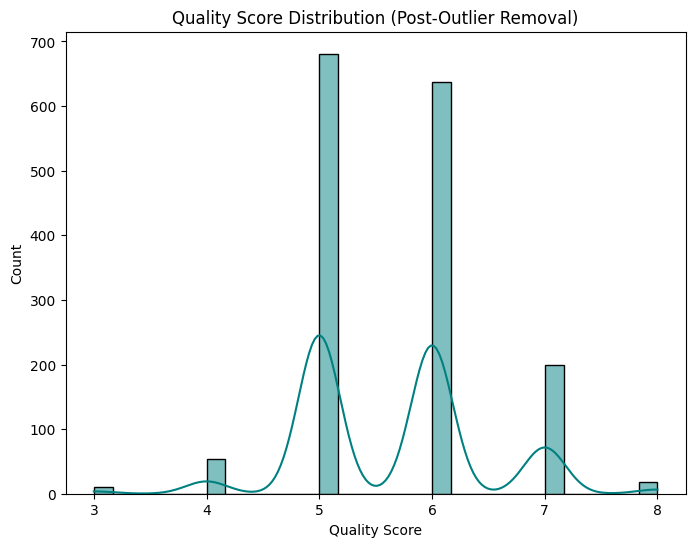

In [ ]:
# Visualizations for Regression
# Histogram of quality scores
plt.figure(figsize=(8, 6))
sns.histplot(df_reg[quality_col], kde=True, color='teal')
plt.title('Quality Score Distribution (Post-Outlier Removal)')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.show()

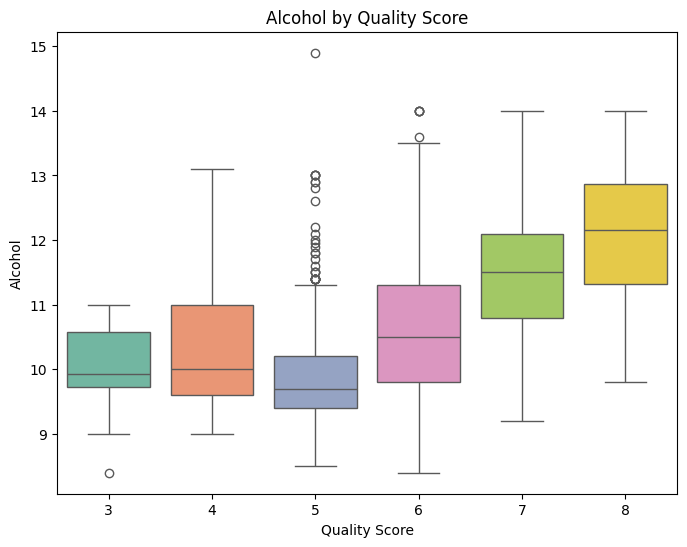

In [ ]:
# Boxplot: Alcohol by Quality
plt.figure(figsize=(8, 6))
sns.boxplot(x='quality', y='alcohol', data=df_reg, palette='Set2')
plt.title('Alcohol by Quality Score')
plt.xlabel('Quality Score')
plt.ylabel('Alcohol')
plt.show()

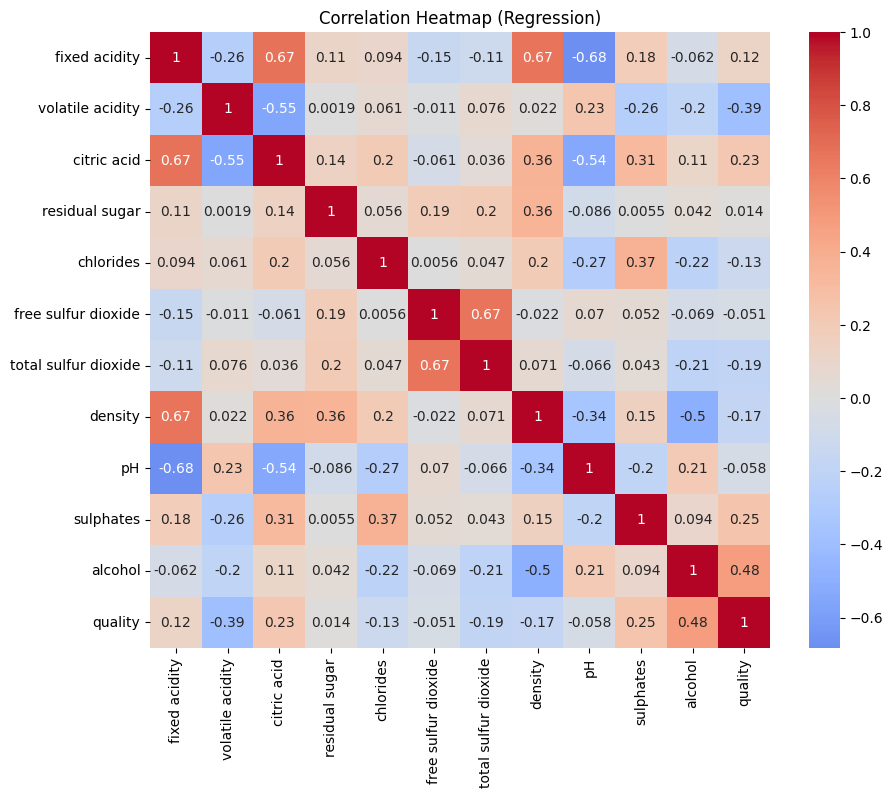

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_reg.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Regression)')
plt.show()

In [ ]:
# 4. Data Preparation for Classification (High vs. Low/Medium Quality)
# Binarize quality: >=7 is high (1), <7 is low/medium (0)
df['quality_class'] = (df['quality'] >= 7).astype(int)

In [ ]:
# Check class distribution
print("\nClassification: Class Distribution")
print(df['quality_class'].value_counts())


Classification: Class Distribution
quality_class
0    1382
1     217
Name: count, dtype: int64


In [ ]:
# Features and target
X_cls = df.drop(['quality', 'quality_class'], axis=1)
y_cls = df['quality_class']

In [ ]:
# Feature selection
selector = SelectKBest(f_classif, k=8)
X_cls_selected = selector.fit_transform(X_cls, y_cls)
selected_features = X_cls.columns[selector.get_support()].tolist()
print("\nSelected Features for Classification:", selected_features)



Selected Features for Classification: ['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']


In [ ]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_cls_smote, y_cls_smote = smote.fit_resample(X_cls_selected, y_cls)
print("\nClass Distribution Post-SMOTE:")
print(pd.Series(y_cls_smote).value_counts())


Class Distribution Post-SMOTE:
quality_class
0    1382
1    1382
Name: count, dtype: int64


In [ ]:
# Feature scaling
scaler_cls = StandardScaler()
X_cls_scaled = scaler_cls.fit_transform(X_cls_smote)

In [ ]:
# Split data
X_train_cls, X_temp_cls, y_train_cls, y_temp_cls = train_test_split(X_cls_scaled, y_cls_smote, test_size=0.2, random_state=42)
X_val_cls, X_test_cls, y_val_cls, y_test_cls = train_test_split(X_temp_cls, y_temp_cls, test_size=0.5, random_state=42)

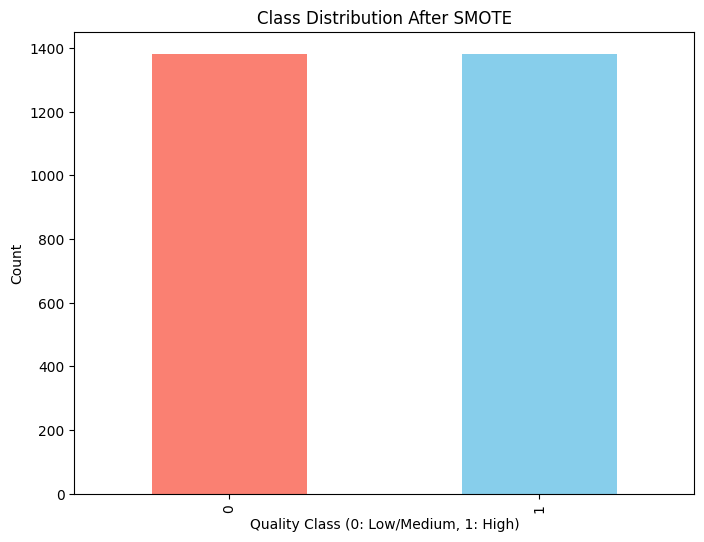

In [ ]:
# Visualizations for Classification
# Bar chart: Class distribution post-SMOTE
plt.figure(figsize=(8, 6))
pd.Series(y_cls_smote).value_counts().plot(kind='bar', color=['salmon', 'skyblue'])
plt.title('Class Distribution After SMOTE')
plt.xlabel('Quality Class (0: Low/Medium, 1: High)')
plt.ylabel('Count')
plt.show()

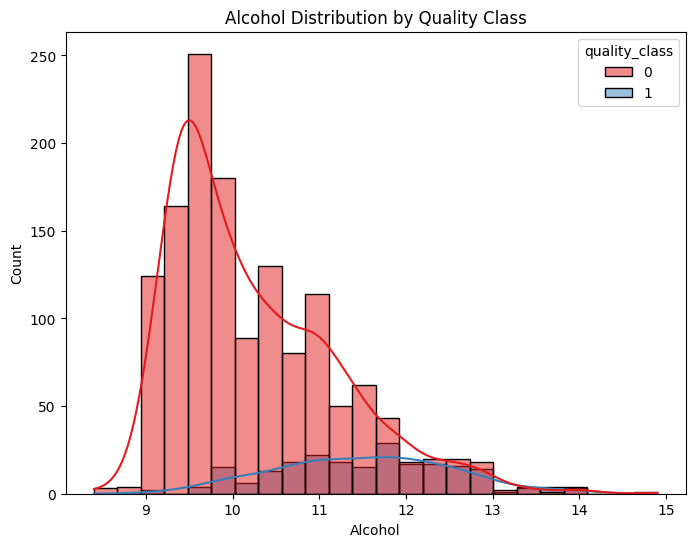

In [ ]:
# Histogram: Alcohol by Quality Class
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='alcohol', hue='quality_class', kde=True, palette='Set1')
plt.title('Alcohol Distribution by Quality Class')
plt.xlabel('Alcohol')
plt.ylabel('Count')
plt.show()

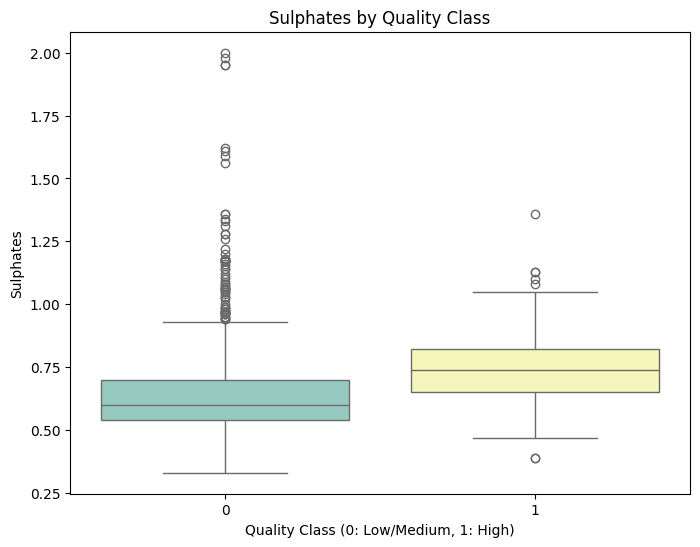

In [ ]:
# Boxplot: Sulphates by Quality Class
plt.figure(figsize=(8, 6))
sns.boxplot(x='quality_class', y='sulphates', data=df, palette='Set3')
plt.title('Sulphates by Quality Class')
plt.xlabel('Quality Class (0: Low/Medium, 1: High)')
plt.ylabel('Sulphates')
plt.show()

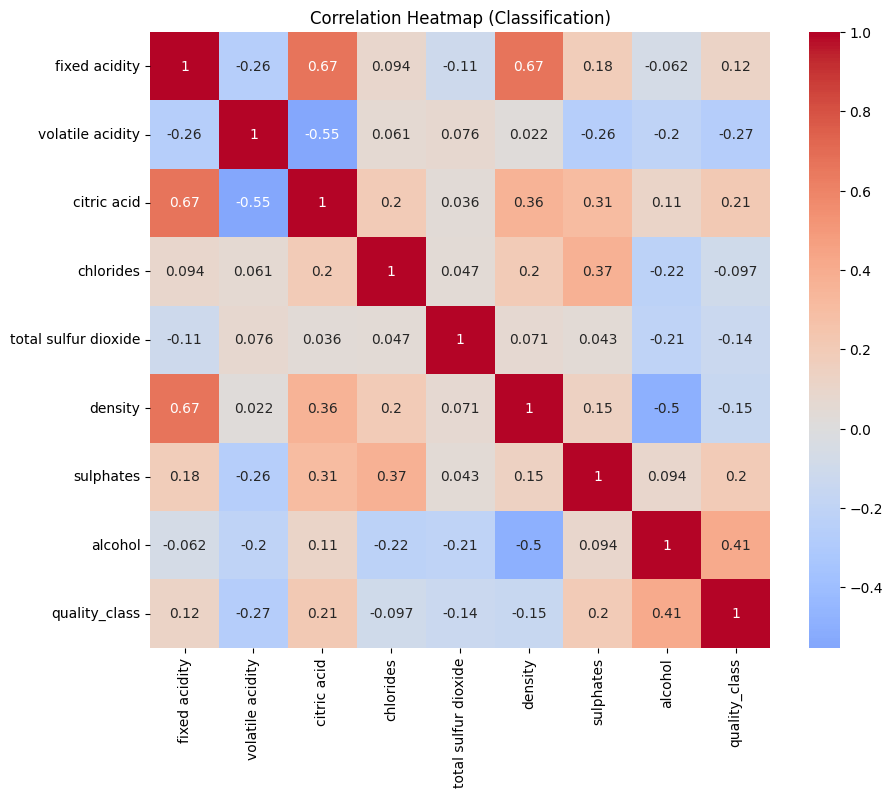

In [ ]:
# Correlation Heatmap (selected features)
plt.figure(figsize=(10, 8))
sns.heatmap(df[selected_features + ['quality_class']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Classification)')
plt.show()

In [ ]:
# 5. Modeling
# Regression: Linear Regression
reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)
y_val_pred_reg = reg_model.predict(X_val_reg)
rmse_val_reg = np.sqrt(mean_squared_error(y_val_reg, y_val_pred_reg))
print("\nRegression: Validation RMSE:", rmse_val_reg)


Regression: Validation RMSE: 0.649165300616656


In [ ]:
# Classification: Logistic Regression
cls_model = LogisticRegression(random_state=42)
cls_model.fit(X_train_cls, y_train_cls)
y_val_pred_cls = cls_model.predict(X_val_cls)
accuracy_val_cls = accuracy_score(y_val_cls, y_val_pred_cls)
print("\nClassification: Validation Accuracy:", accuracy_val_cls)
print("\nClassification Report:")
print(classification_report(y_val_cls, y_val_pred_cls))


Classification: Validation Accuracy: 0.8079710144927537

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.82       150
           1       0.76      0.84      0.80       126

    accuracy                           0.81       276
   macro avg       0.81      0.81      0.81       276
weighted avg       0.81      0.81      0.81       276



In [ ]:
# 6. Data Quality Review
# Regression
print("\nRegression: Post-Processing Checks")
print("Scaled Features Mean:", X_reg_scaled.mean(axis=0))
print("Scaled Features Std:", X_reg_scaled.std(axis=0))
print("Outliers Removed:", len(df) - len(df_reg))


Regression: Post-Processing Checks
Scaled Features Mean: [ 3.55493551e-16  1.73303106e-16 -8.88733878e-17 -1.24422743e-16
  3.73268229e-16 -6.22113715e-17  4.44366939e-17 -3.47317200e-14
  2.86172309e-15  6.75437748e-16  1.06648065e-16]
Scaled Features Std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Outliers Removed: 0


CLASSIFICATION

In [ ]:
# Classification
print("\nClassification: Post-Processing Checks")
print("Selected Features Count:", len(selected_features))
print("Class Balance Post-SMOTE:", pd.Series(y_cls_smote).value_counts())


Classification: Post-Processing Checks
Selected Features Count: 8
Class Balance Post-SMOTE: quality_class
0    1382
1    1382
Name: count, dtype: int64


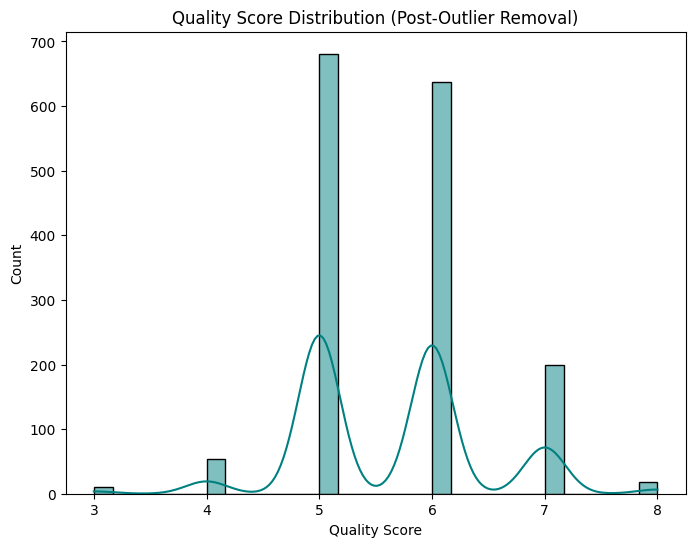

In [ ]:
# 7. Save Visualizations (Optional)
# Save histogram of quality scores
plt.figure(figsize=(8, 6))
sns.histplot(df_reg['quality'], kde=True, color='teal')
plt.title('Quality Score Distribution (Post-Outlier Removal)')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.savefig('quality_histogram.png')

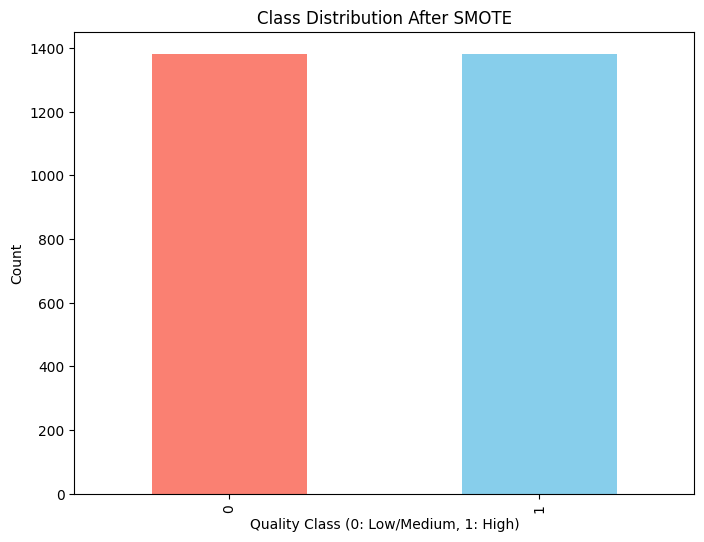

In [ ]:
# Save class distribution bar chart
plt.figure(figsize=(8, 6))
pd.Series(y_cls_smote).value_counts().plot(kind='bar', color=['salmon', 'skyblue'])
plt.title('Class Distribution After SMOTE')
plt.xlabel('Quality Class (0: Low/Medium, 1: High)')
plt.ylabel('Count')
plt.savefig('class_distribution_smote.png')

Learning Aim C

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prepare binary labels for classification (e.g., good quality = 1 if quality >= 6)
df['good_quality'] = [1 if q >= 6 else 0 for q in df['quality']]

# Features and labels
X = df.drop(['quality', 'good_quality'], axis=1)
y = df['good_quality']

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict (this is what you should use!)
y_pred_class = log_reg.predict(X_test)


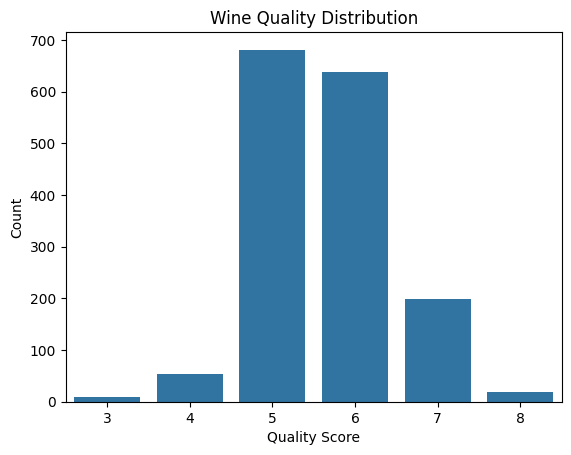

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='quality', data=df)
plt.title('Wine Quality Distribution')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Binary classification
df['quality_binary'] = df['quality'].apply(lambda x: 1 if x >= 6 else 0)
X = df.drop(['quality', 'quality_binary'], axis=1)
y = df['quality_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


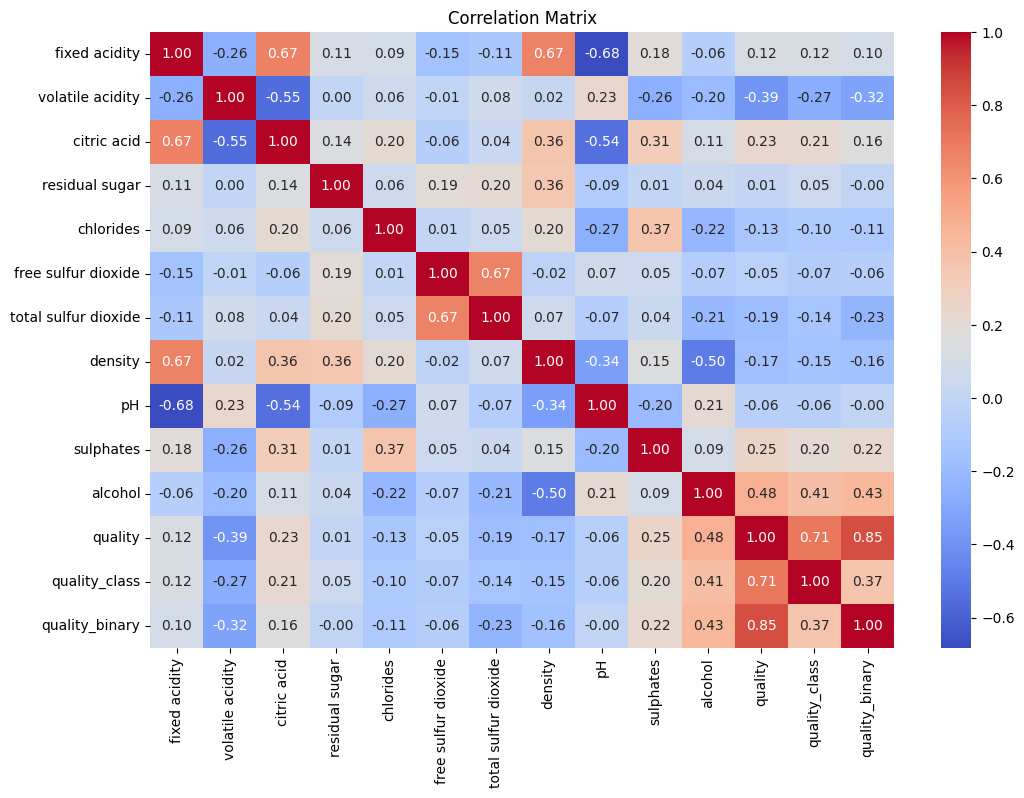

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


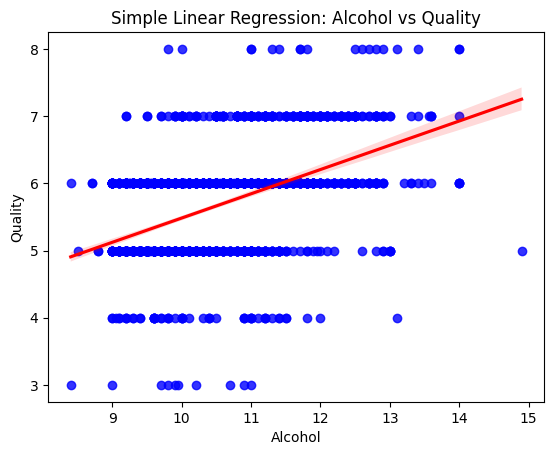

In [ ]:
sns.regplot(x='alcohol', y='quality', data=df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('Simple Linear Regression: Alcohol vs Quality')
plt.xlabel('Alcohol')
plt.ylabel('Quality')
plt.show()


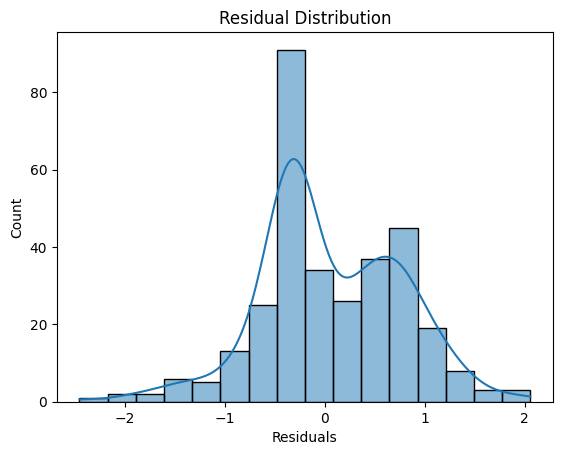

In [ ]:
import numpy as np

residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.show()

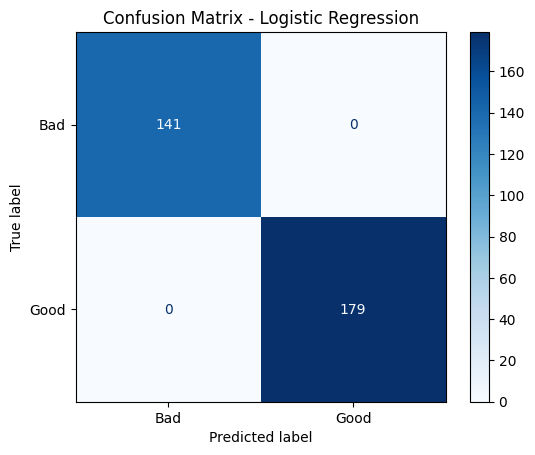

In [ ]:
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad', 'Good'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()
